In [1]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras import Model,Input
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM,TimeDistributed,ConvLSTM2D
from matplotlib import pyplot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
def train_test(data, n_test):
	return data[:-n_test], data[-n_test:]


def medir_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

In [3]:
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	
	train, test = train_test(data, n_test)

	
	model = model_fit(train, cfg)
	
	data_historica = [x for x in train]
	
	for i in range(len(test)):
		
		yhat = model_predict(model, data_historica, cfg)
		
		predictions.append(yhat)
		
		data_historica.append(test[i])
	
	error = medir_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

In [4]:
def repetir(data, config, n_test, n_repeats=30):
	
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores

In [5]:
def summarize_scores(name, scores):
	
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.f RMSE (+/- %.f)' % (name, scores_m, score_std))
	
	pyplot.boxplot(scores)
	pyplot.show()

In [6]:
def supervised_ts(data, n_in, n_out=1):
	df = DataFrame(data)
	cols = list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	agg = concat(cols, axis=1)
	agg.dropna(inplace=True)
	return agg.values

In [24]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv"
#s = requests.get(url).content
#data = read_csv(io.StringIO(s.decode('utf-8')))
series_ = read_csv(url, header=0, index_col=0) 
#data = series.values
data_ = series.values
data_.shape

(108, 1)

In [25]:
series_

,Sales
Month,
1960-01,6550
1960-02,8728
1960-03,12026
1960-04,14395
1960-05,14587
...,...
1968-08,16722
1968-09,14385
1968-10,21342


In [29]:
df=pd.read_csv("Daily_Demand_Forecasting_Orders.csv")
dataframe = pd.DataFrame(df['Week of the month (first week'].str.split(';',13).tolist(),
                    columns = 
                    ['fourth','Day_of_the_week','Non-urgent-order',
                     'Urgent-order','OrderA','OrderB','OrderC','Fiscal','traffic-orders',
                     'Banking-orders-1','Banking-orders-2','Banking-orders-3','target'])

dataframe = dataframe.astype(float)
#dataframe.head()
series=dataframe[['OrderB']]
data=array(series)
data.shape

(60, 1)

In [33]:
seriesF=dataframe[['Day_of_the_week','OrderB']][0:20]
seriesF

,Day_of_the_week,OrderB
0,4.0,175.586
1,5.0,56.037
2,6.0,25.125
3,2.0,113.294
4,3.0,56.618
5,4.0,50.704
6,5.0,66.371
7,6.0,85.961
8,2.0,148.274
9,3.0,43.306


#CNN

In [8]:

def model_fit(train, config):
	
	n_input, n_filters, n_kernel, n_epochs, n_batch = config
	data = supervised_ts(train, n_input)
	train_x, train_y = data[:, :-1], data[:, -1]
	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
	model = Sequential()
	model.add(Conv1D(n_filters, n_kernel, activation='relu', input_shape=(n_input, 1)))
	model.add(Conv1D(n_filters, n_kernel, activation='relu'))
	model.add(MaxPooling1D())
	model.add(Flatten())
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

def model_predict(model, history, config):
	n_input, _, _, _, _ = config
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

 > 77.205
 > 74.029
 > 70.744
 > 79.221
 > 79.658
 > 76.676
 > 74.546
 > 75.518
 > 76.780
 > 75.304
 > 76.368
 > 82.306
 > 72.266
 > 80.363
 > 84.017
 > 81.500
 > 83.293
 > 79.664
 > 77.222
 > 83.098
 > 70.613
 > 75.706
 > 69.105
 > 79.713
 > 77.271
 > 81.998
 > 85.298
 > 72.797
 > 77.449
 > 81.360
cnn: 78 RMSE (+/- 4)


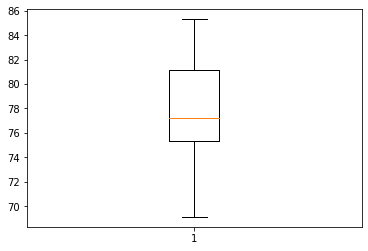

In [9]:
# cnn configuracion
n_test=12
config = [36, 256, 3, 100, 100]
scores = repetir(data, config, n_test)
summarize_scores('cnn', scores)

#LSTM

In [10]:
# diferenciar data
def differenciar(data, interval):
	return [data[i] - data[i - interval] for i in range(interval, len(data))]

In [11]:
def model_fit(train, config):
	n_input, n_nodes, n_epochs, n_batch, n_diff = config
    #config = [36, 50, 100, 100, 12]
	if n_diff > 0:
		train = differenciar(train, n_diff)
	data = supervised_ts(train, n_input)
	train_x, train_y = data[:, :-1], data[:, -1]
	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
	model = Sequential()
	model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

def model_predict(model, history, config):
	n_input, _, _, _, n_diff = config
	correction = 0.0
	if n_diff > 0:
		correction = history[-n_diff]
		history = differenciar(history, n_diff)
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return correction + yhat[0]

 > 95.896
 > 82.689
 > 87.791
 > 103.488
 > 85.756
 > 82.173
 > 115.095
 > 146.703
 > 97.102
 > 78.178
 > 91.637
 > 75.595
 > 98.917
 > 151.437
 > 76.211
 > 91.935
 > 82.892
 > 95.274
 > 130.927
 > 125.594
 > 76.370
 > 95.032
 > 97.232
 > 80.853
 > 98.930
 > 100.530
 > 85.350
 > 140.597
 > 83.493
 > 94.818
lstm: 98 RMSE (+/- 21)


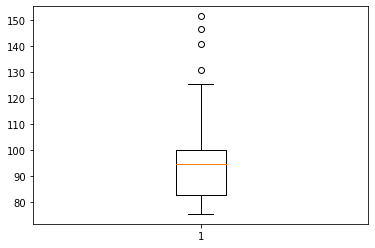

In [16]:
n_test = 12
config = [36, 50, 100, 100, 5]
#config = [36, 256, 3, 100, 100]
scores = repetir(data, config, n_test)
summarize_scores('lstm', scores)

#CNN+LSTM

In [ ]:
#input [4 dimensiones]
# lags = n_subseq x n_steps 

In [17]:
def model_fit(train, config):
  n_subseq, n_steps, n_filtros, size_kernel,n_nodos,n_epoch, n_batch = config
  n_time_step = n_subseq*n_steps
  data = supervised_ts(train, n_time_step)
  train_x, train_y = data[:, :-1], data[:, -1]
  train_x = train_x.reshape((train_x.shape[0], n_subseq, n_steps, 1))
  #conf model
  model = Sequential()
  # CNN
  model.add(TimeDistributed(Conv1D(n_filtros,size_kernel,activation='relu',input_shape=(None,n_steps,1))))
  model.add(TimeDistributed(Conv1D(n_filtros,size_kernel,activation='relu')))
  model.add(TimeDistributed(MaxPooling1D()))
  model.add(TimeDistributed(Flatten()))
  # LSTM
  model.add(LSTM(n_nodos,activation='relu'))
  model.add(Dense(n_nodos, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  model.fit(train_x, train_y, epochs=n_epoch, batch_size=n_batch, verbose=0)
  return model

In [18]:
def model_predict(model, history, config):
	n_subseq, n_steps,_,_, _,_,_ = config
	
	#if n_diff > 0:
	#	correction = history[-n_diff]
	#	history = differenciar(history, n_diff)
	x_input = array(history[-n_subseq*n_steps:]).reshape((1, n_subseq,n_steps, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return  yhat[0]

In [19]:
# 36 timestesps
conf=[6,6,64,3,100,200,64]
n_test=12

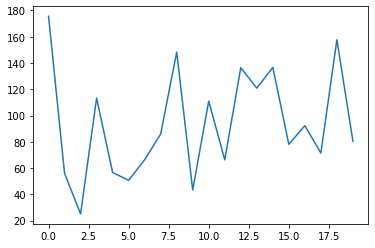

In [37]:
seriesF['OrderB'].plot()
pyplot.show()

 > 74.210
 > 56.325
 > 67.954
 > 56.269
 > 79.537
 > 81.748
 > 47.496
 > 49.376
 > 63.536
 > 89.755
 > 80.348
 > 127.297
 > 83.782
 > 73.572
 > 52.979
 > 93.028
 > 51.347
 > 66.266
 > 64.223
 > 79.922
 > 71.188
 > 86.459
 > 85.079
 > 75.666
 > 79.635
 > 58.734
 > 67.888
 > 50.972
 > 86.777
 > 58.653
cnn+lstm: 72 RMSE (+/- 17)


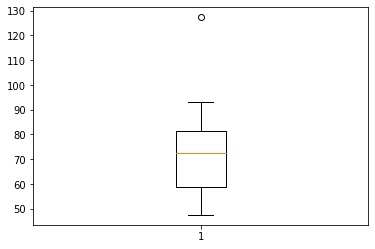

In [38]:
scores=repetir(data,conf,n_test)

summarize_scores('cnn+lstm',scores)

#CONVLSTM


In [40]:
def model_fit(train, config):
  n_subseq, n_steps, n_filtros, size_kernel,n_nodos,n_epoch, n_batch = config
  n_time_step = n_subseq*n_steps
  data = supervised_ts(train, n_time_step)
  train_x, train_y = data[:, :-1], data[:, -1]
  train_x = train_x.reshape((train_x.shape[0], n_subseq,1, n_steps, 1))
  #conf model
  model = Sequential()
  # convLSTM
  model.add(ConvLSTM2D(n_filtros,(1,size_kernel),activation='relu',input_shape=(n_subseq,1,n_steps,1)))
  model.add(Flatten())
  model.add(Dense(n_nodos, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  model.fit(train_x, train_y, epochs=n_epoch, batch_size=n_batch, verbose=0)
  return model

In [41]:
def model_predict(model, history, config):
	n_subseq, n_steps,_,_, _,_,_ = config
	
	#if n_diff > 0:
	#	correction = history[-n_diff]
	#	history = differenciar(history, n_diff)
	x_input = array(history[-n_subseq*n_steps:]).reshape((1, n_subseq,1,n_steps, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return  yhat[0]

In [42]:
# 36 timestesps
conf=[3,12,180,3,200,200,64]
n_test=12

In [43]:
scores=repetir(data,conf,n_test,20)

 > 56.308
 > 60.659
 > 54.692
 > 63.026
 > 54.923
 > 60.518
 > 56.572
 > 59.881
 > 59.425
 > 63.847
 > 61.774
 > 56.585
 > 55.026
 > 56.568
 > 54.602
 > 59.184
 > 62.298
 > 64.209
 > 57.834
 > 55.302


convlstm: 59 RMSE (+/- 3)


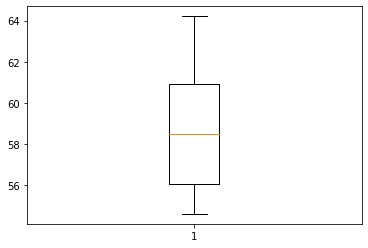

In [44]:
summarize_scores('convlstm',scores)

#INTERVALOS DE PREDIC...

In [45]:
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	
	train, test = train_test(data, n_test)

	
	model = model_fit(train, cfg)
	
	data_historica = [x for x in train]
	
	for i in range(len(test)):
		
		yhat = model_predict(model, data_historica, cfg)
		
		predictions.append(yhat)
		
		data_historica.append(test[i])
	
	error = medir_rmse(test, predictions)
	print(' > %.3f' % error)
	return [error,model]

In [46]:
def repetir(data, config, n_test, n_repeats=30):
  walk_forward_validation_list = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
  scores = [row[0] for row in walk_forward_validation_list]
  models = [row[1] for row in walk_forward_validation_list]
  return scores,models



In [47]:
# cnn
def model_fit(train, config):
  n_steps, n_filtros, size_kernel,n_epoch, n_batch, dropout_rate = config
  #n_time_step = n_subseq*n_steps
  data = supervised_ts(train, n_steps)
  train_x, train_y = data[:, :-1], data[:, -1]
  train_x = train_x.reshape((train_x.shape[0],train_x.shape[1], 1))
  
  #conf model
  inputs = Input(shape=(n_steps,1))
  x= Conv1D(n_filtros,size_kernel,activation='relu')(inputs)
  x= Dropout(dropout_rate)(x, training=True)
  x= Conv1D(n_filtros,size_kernel,activation='relu')(x)
  x= Dropout(dropout_rate)(x, training=True)
  x= MaxPooling1D()(x)
  x= Flatten()(x)
  outputs=Dense(1)(x)
  model = Model(inputs,outputs)
  model.compile(loss='mse',optimizer='adam')
  model.fit(train_x, train_y, epochs=n_epoch, batch_size=n_batch, verbose=0)
  return model

In [48]:
def model_predict(model, history, config):
	n_input, _, _, _, _,_ = config
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

 > 81.873
 > 89.616
 > 85.212
cnn+intervals: 86 RMSE (+/- 3)


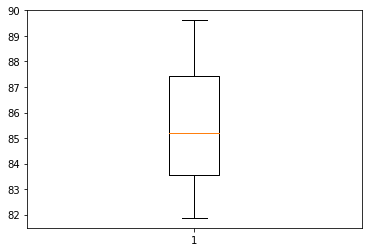

In [49]:
n_test=12
config=[36,256,3,100,80,0.25]

scores,models = repetir(data,config,n_test,3)
summarize_scores('cnn+intervals',scores)

In [50]:
print(models[2].summary())

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 36, 1)]           0         
_________________________________________________________________
conv1d_184 (Conv1D)          (None, 34, 256)           1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 34, 256)           0         
_________________________________________________________________
conv1d_185 (Conv1D)          (None, 32, 256)           196864    
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 256)           0         
_________________________________________________________________
max_pooling1d_92 (MaxPooling (None, 16, 256)           0         
_________________________________________________________________
flatten_112 (Flatten)        (None, 4096)             

In [52]:
# get intervals
def get_intervals(model,data,config,n_test,n_repeticiones=100):
  train,test = train_test(data,n_test)
  predictions_list = []
  data_historica = [x for x in train]
  for t in range(n_repeticiones):
    data_historica_temp=data_historica
    predictions=list()
    for i in range(len(test)):
      yhat = model_predict(model, data_historica_temp, config)
      predictions.append(yhat)
      data_historica_temp.append(test[i])
		#data_historica.append(test[i])
    predictions_list.append(predictions)
      
  return predictions_list

In [53]:
prediction_interval= get_intervals(models[2],data,config,n_test)

In [54]:
prediction_df=pd.DataFrame()
prediction_df['mean']=np.array(prediction_interval).mean(axis=0).reshape(-1,)

In [55]:
x=array(prediction_interval)

In [56]:
x.shape

(100, 12, 1)

In [57]:
x=x.reshape((-1))
x=x.reshape(100,n_test)

In [58]:
#intervalos
ic=0.95
lim_inferior=np.quantile(x.T,0.5-ic/2,axis=1)
lim_sup=np.quantile(x.T,0.5+ic/2,axis=1)

In [59]:
train,test = train_test(data,n_test)

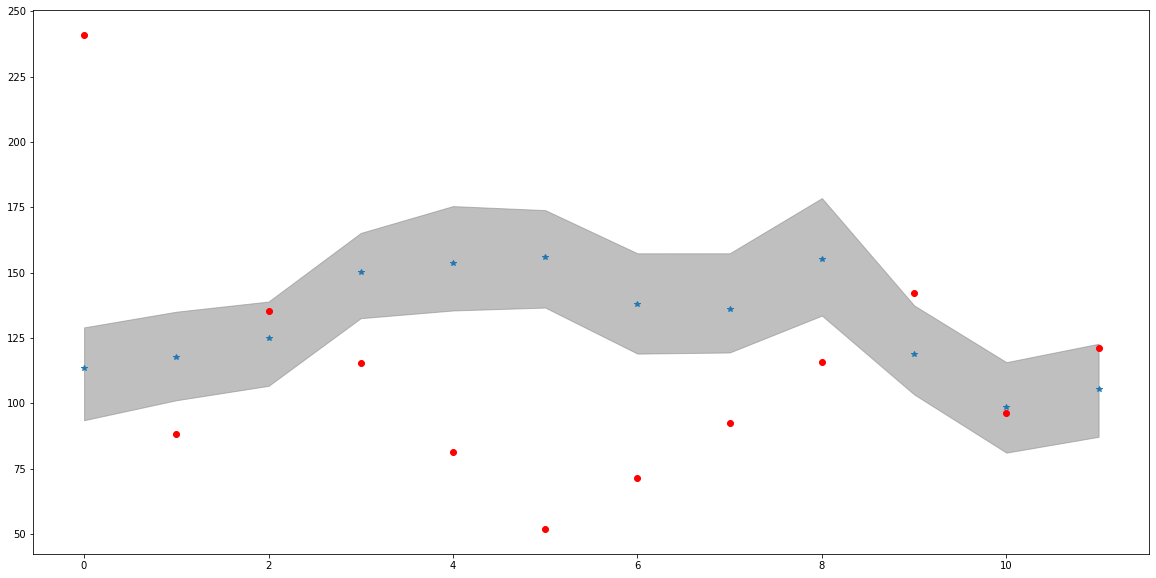

In [60]:
plt.figure(figsize=(20,10))
plt.plot([i for i in range(len(test))],test,'or')
plt.plot([i for i in range(len(test))],prediction_df['mean'].values,'*')
plt.fill_between([i for i in range(len(test))],lim_sup,lim_inferior,color='gray',alpha=0.5)
#plt.plot([i for i in range(len(test))],test,'or')
#plt.plot([i for i in range(len(test))],test,'or')

In [61]:
def split_sequence_multistep(sequence, n_steps, n_outputs):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        out_end = end_ix + n_outputs
        if out_end > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
def split_sequence_multistep_multivar(sequence, n_steps, n_outputs):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        out_end = end_ix + n_outputs-1
        if out_end > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix,:-1], sequence[end_ix-1:out_end,-1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
arrayX=dataframe[['OrderB']]
#arrayX

from numpy import array
arrayX=array(arrayX)
n_steps,n_steps_out=3,2
X_enco_deco,y_enco_deco=split_sequence_multistep(arrayX,n_steps,n_steps_out)
#y_enco_deco
n_features=1

X_enco_deco=X_enco_deco.reshape((X_enco_deco.shape[0],X_enco_deco.shape[1],n_features))
y_enco_deco=y_enco_deco.reshape((y_enco_deco.shape[0],y_enco_deco.shape[1],n_features))


In [62]:
from keras.layers import RepeatVector
from keras.layers import LSTM
model_enco_deco=Sequential()
#encoder:
model_enco_deco.add(LSTM(80,activation='relu',input_shape=(n_steps,n_features)))
#repetir el vector d contexto
model_enco_deco.add(RepeatVector(n_steps_out))


In [63]:
#decoder:
model_enco_deco.add(LSTM(150,activation='relu',return_sequences=True))

In [64]:
from keras.layers import TimeDistributed

model_enco_deco.add(TimeDistributed(Dense(1)))

In [65]:
model_enco_deco.compile(optimizer='adam',loss='mse')
history=model_enco_deco.fit(X_enco_deco,y_enco_deco,epochs=800)

Epoch 1/800
2/2 [==============================] - 0s 7ms/step - loss: 14209.9893
Epoch 2/800
2/2 [==============================] - 0s 8ms/step - loss: 13488.6982
Epoch 3/800
2/2 [==============================] - 0s 8ms/step - loss: 12826.5166
Epoch 4/800
2/2 [==============================] - 0s 9ms/step - loss: 12012.7549
Epoch 5/800
2/2 [==============================] - 0s 8ms/step - loss: 10983.7900
Epoch 6/800
2/2 [==============================] - 0s 8ms/step - loss: 9693.2324
Epoch 7/800
2/2 [==============================] - 0s 9ms/step - loss: 8290.9668
Epoch 8/800
2/2 [==============================] - 0s 8ms/step - loss: 6665.2969
Epoch 9/800
2/2 [==============================] - 0s 9ms/step - loss: 5665.5264
Epoch 10/800
2/2 [==============================] - 0s 8ms/step - loss: 5369.4741
Epoch 11/800
2/2 [==============================] - 0s 8ms/step - loss: 5435.6528
Epoch 12/800
2/2 [==============================] - 0s 9ms/step - loss: 5209.2256
Epoch 13/800
2/2 [==

In [66]:
X_enco_deco[0]

array([[175.586],
       [ 56.037],
       [ 25.125]])

In [68]:
x_test=X_enco_deco[0]

In [69]:
x_test=x_test.reshape((1,n_steps,n_features))

In [70]:
y_test=model_enco_deco.predict(x_test)

In [71]:
y_test

array([[[110.180016],
        [ 51.68129 ]]], dtype=float32)

In [72]:
y_enco_deco[0]

array([[113.294],
       [ 56.618]])

In [73]:
import matplotlib.pyplot as plt
print(history.history.keys())

dict_keys(['loss'])


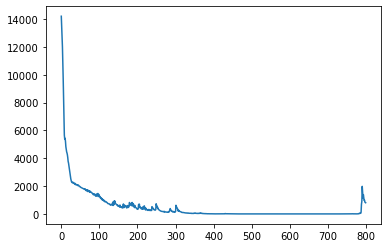

In [74]:
xc= range(800)
val_loss   = history.history['loss']
plt.plot(xc, val_loss)


In [ ]:
#lo mejor sería escoger 300